# CHSH Bell Inequality - SOLUTION

**Complete solution for instructors**

---

## Setup

In [1]:
import random
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

GLOBAL_SEED = 91
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

aer_simulator = AerSimulator()
MANUAL_SIMULATOR_SEED_COUNTER = GLOBAL_SEED

ALICE_BELL_BASES = ['0', '90']
BOB_BELL_BASES = ['45', '135']

# Theoretical classical limit is 2.0
# In practice, we use a stricter threshold of 2.5 to account for:
#   - Statistical noise in finite shot experiments
#   - Gate errors and decoherence on real hardware
#   - Results must clearly approach the quantum maximum (2√2 ≈ 2.828)
#
# Interpretation:
#   |S| < 2.0       → Classical regime (no violation)
#   2.0 < |S| < 2.5 → Caution: theoretical violation, but may be due to noise or
#                     insufficient statistics (this boundary is a pedagogical choice,
#                     not a scientifically established threshold)
#   |S| > 2.5       → Robust violation, clearly quantum
BELL_INEQUALITY_THRESHOLD = 2.5

print("Setup complete!")
print(f"Alice's bases: {ALICE_BELL_BASES}")
print(f"Bob's bases: {BOB_BELL_BASES}")

Setup complete!
Alice's bases: ['0', '90']
Bob's bases: ['45', '135']


In [2]:
def run_circuit(circ: QuantumCircuit, shots=1) -> dict:
    global MANUAL_SIMULATOR_SEED_COUNTER
    global aer_simulator
    
    current_run_seed = MANUAL_SIMULATOR_SEED_COUNTER
    MANUAL_SIMULATOR_SEED_COUNTER += 1
    
    circ = transpile(circ, aer_simulator)
    result = aer_simulator.run(circ, shots=shots, seed_simulator=current_run_seed).result()
    return result.get_counts(circ)

print("Helper function loaded!")

Helper function loaded!


## 1) Create Bell State

In [3]:
#  SOLUTION
def create_bell_pair_singlet_state() -> QuantumCircuit:
    """
    Create the Bell singlet state |Ψ-⟩ = (|01⟩ - |10⟩)/√2
    """
    qc = QuantumCircuit(2)
    
    # Step 1: Create superposition
    qc.h(0)
    
    # Step 2: Entangle qubits
    qc.cx(0, 1)
    
    # Step 3: Transform to |Ψ-⟩
    qc.x(1)
    qc.z(1)
    
    return qc

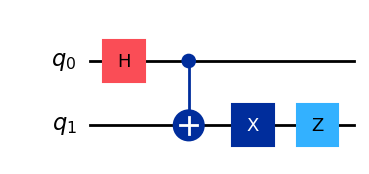

In [4]:
# Test your Bell state
bell_state = create_bell_pair_singlet_state()
bell_state.draw('mpl')

In [5]:
# Test
test_qc = bell_state.copy()
test_qc.measure_all()
counts = run_circuit(test_qc, shots=1000)
print(f"Results: {counts}")

Results: {'01': 512, '10': 488}


## 2) Basis Transformation

In [6]:
# SOLUTION
def apply_basis_transformation(circuit: QuantumCircuit, qubit_index: int, basis: str) -> QuantumCircuit:
    transformed = circuit.copy()
    
    if basis == '0':
        pass
    elif basis == '90':
        transformed.h(qubit_index)
    elif basis == '45':
        transformed.ry(-np.pi/4, qubit_index)
    elif basis == '135':
        transformed.ry(-3*np.pi/4, qubit_index)
    else:
        raise ValueError(f"Unknown basis: {basis}")
    
    return transformed

In [7]:
#  Test basis transformations
test_qc = QuantumCircuit(1)

print("Testing basis transformations:")
for basis in ['0', '45', '90', '135']:
    result = apply_basis_transformation(test_qc, 0, basis)
    print(f"\nBasis {basis}°:")
    print(result.draw())

Testing basis transformations:

Basis 0°:
   
q: 
   

Basis 45°:
   ┌──────────┐
q: ┤ Ry(-π/4) ├
   └──────────┘

Basis 90°:
   ┌───┐
q: ┤ H ├
   └───┘

Basis 135°:
   ┌───────────┐
q: ┤ Ry(-3π/4) ├
   └───────────┘


## 3) Measure Bell Pair

In [8]:
#  SOLUTION
def measure_bell_pair(circuit: QuantumCircuit, alice_basis: str, bob_basis: str) -> str:
    meas_qc = circuit.copy()
    
    # Apply basis transformations
    meas_qc = apply_basis_transformation(meas_qc, 0, alice_basis)
    meas_qc = apply_basis_transformation(meas_qc, 1, bob_basis)
    
    # Measure
    meas_qc.measure_all()
    
    # Run and return result
    counts = run_circuit(meas_qc, shots=1)
    return list(counts.keys())[0]

In [10]:
# Test Bell pair measurement
bell_state = create_bell_pair_singlet_state()
from collections import Counter

num_experiments = 200

# Test multiple measurements
print(f"Testing Bell pair measurements ({num_experiments} runs each)")

print("\nDifferent bases (Alice 0°, Bob 45°) - Random results:")
results_diff = [measure_bell_pair(bell_state, '0', '45') for _ in range(num_experiments)]
print(f"  Counts: {dict(Counter(results_diff))}")

print("\nSame bases (Alice 0°, Bob 0°) - Perfect Anti-correlation:")
# For Singlet State |Ψ-⟩, same-basis measurements must be opposite ('01' or '10')
results_same = [measure_bell_pair(bell_state, '0', '0') for _ in range(num_experiments)]
print(f"  Counts: {dict(Counter(results_same))}")


Testing Bell pair measurements (200 runs each)

Different bases (Alice 0°, Bob 45°) - Random results:
  Counts: {'01': 98, '10': 69, '11': 18, '00': 15}

Same bases (Alice 0°, Bob 0°) - Perfect Anti-correlation:
  Counts: {'10': 86, '01': 114}


## 4) Run Bell Test Measurements

In [11]:
# SOLUTION
def run_bell_test_measurements(list_bell_pairs, list_alice_bases=ALICE_BELL_BASES, list_bob_bases=BOB_BELL_BASES):
    results = []
    alice_bases_used = []
    bob_bases_used = []
    
    for qc in list_bell_pairs:
        a_base = random.choice(list_alice_bases)
        b_base = random.choice(list_bob_bases)
        result = measure_bell_pair(qc, a_base, b_base)
        
        results.append(result)
        alice_bases_used.append(a_base)
        bob_bases_used.append(b_base)
    
    return results, alice_bases_used, bob_bases_used

## 5) Organize by Basis

In [12]:
# SOLUTION
def organize_measurements_by_basis(results, alice_bases, bob_bases):
    unique_alice = list(set(alice_bases))
    unique_bob = list(set(bob_bases))
    
    counts = {}
    for a in unique_alice:
        for b in unique_bob:
            counts[(a, b)] = {'00': 0, '01': 0, '10': 0, '11': 0}
    
    for i, result in enumerate(results):
        a_base = alice_bases[i]
        b_base = bob_bases[i]
        counts[(a_base, b_base)][result] += 1
    
    return counts

## 6) Calculate Correlations

In [13]:
# SOLUTION
def calculate_correlations(measurements):
    correlations = {}
    
    for basis_pair, results in measurements.items():
        total = sum(results.values())
        
        if total > 0:
            E = (results['00'] + results['11'] - results['01'] - results['10']) / total
            correlations[basis_pair] = E
        else:
            correlations[basis_pair] = 0
    
    print("Correlations:")
    for basis, corr in correlations.items():
        print(f"  E{basis} = {corr:.4f}")
    
    return correlations

## 7) Calculate CHSH

In [14]:
# SOLUTION
def calculate_chsh_value(correlations, alice_bases=ALICE_BELL_BASES, bob_bases=BOB_BELL_BASES):
    a1, a2 = alice_bases
    b1, b2 = bob_bases
    
    S = correlations[(a1, b1)] - correlations[(a1, b2)] + correlations[(a2, b1)] + correlations[(a2, b2)]
    
    return abs(S)


def check_bell_inequality(chsh_value):
    return chsh_value > BELL_INEQUALITY_THRESHOLD

## Visualization helper (provided)
It is not part of the protocol logic. Use it to see correlations and the CHSH value clearly.

In [15]:
def visualize_bell_test_results(correlations, chsh_value, title="Bell Test Results"):
    fig = plt.figure(figsize=(12, 5))
    
    ax1 = fig.add_subplot(121)
    alice_bases = sorted(set(b[0] for b in correlations.keys()))
    bob_bases = sorted(set(b[1] for b in correlations.keys()))
    corr_matrix = np.zeros((len(alice_bases), len(bob_bases)))
    
    for i, a_base in enumerate(alice_bases):
        for j, b_base in enumerate(bob_bases):
            if (a_base, b_base) in correlations:
                corr_matrix[i, j] = correlations[(a_base, b_base)]
    
    colors = [(0.8, 0.2, 0.2), (1, 1, 1), (0.2, 0.2, 0.8)]
    cmap = LinearSegmentedColormap.from_list('rwb', colors, N=100)
    
    im = ax1.imshow(corr_matrix, cmap=cmap, vmin=-1, vmax=1)
    ax1.set_title('Correlation Values E(a,b)')
    ax1.set_xticks(np.arange(len(bob_bases)))
    ax1.set_yticks(np.arange(len(alice_bases)))
    ax1.set_xticklabels([f"{b}°" for b in bob_bases])
    ax1.set_yticklabels([f"{a}°" for a in alice_bases])
    ax1.set_xlabel("Bob's Angle")
    ax1.set_ylabel("Alice's Angle")
    
    for i in range(len(alice_bases)):
        for j in range(len(bob_bases)):
            ax1.text(j, i, f"{corr_matrix[i, j]:.2f}", ha="center", va="center",
                    color="black" if abs(corr_matrix[i, j]) < 0.5 else "white")
    fig.colorbar(im, ax=ax1)
    
    ax2 = fig.add_subplot(122)
    ax2.bar([0], [chsh_value], width=0.4, color='purple', alpha=0.7)
    ax2.axhline(y=2.0, color='r', linestyle='-', label='Classical Limit (2.0)')
    ax2.axhline(y=2*np.sqrt(2), color='b', linestyle='--', label='Quantum Limit (2√2)')
    ax2.set_ylim(0, 3.0)
    ax2.set_xticks([0])
    ax2.set_xticklabels(['CHSH Value'])
    ax2.text(0, chsh_value + 0.1, f"{chsh_value:.3f}", ha='center')
    ax2.legend(loc='upper left')
    ax2.set_title('CHSH Value vs Limits')
    
    verdict = "✅ Entanglement!" if chsh_value > 2 else "❌ No quantum"
    ax2.text(0, 1.0, verdict, ha='center', fontsize=14, fontweight='bold',
             color='green' if chsh_value > 2 else 'red')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Run Complete Test

In [ ]:
# Run complete test
num_experiments = 200  # you can use a larger number, but execution time will increase

print("Creating Bell pairs...")
bell_pairs = [create_bell_pair_singlet_state() for _ in range(num_experiments)]

print("Running measurements...")
results, alice_bases_used, bob_bases_used = run_bell_test_measurements(bell_pairs)

print("\nOrganizing results...")
organized = organize_measurements_by_basis(results, alice_bases_used, bob_bases_used)

print("\nCalculating correlations...")
correlations = calculate_correlations(organized)

chsh = calculate_chsh_value(correlations)
print(f"\n" + "="*50)
print(f"CHSH VALUE: {chsh:.4f}")
print("="*50)

if check_bell_inequality(chsh):
    print("\n QUANTUM ENTANGLEMENT DETECTED!")
else:
    print("\n No quantum correlations.")

Creating Bell pairs...
Running measurements...

Organizing results...

Calculating correlations...
Correlations:
  E('0', '45') = -0.5349
  E('0', '135') = 0.6786
  E('90', '45') = -0.7447
  E('90', '135') = -0.6296

CHSH VALUE: 2.5878

 QUANTUM ENTANGLEMENT DETECTED!


/var/folders/cn/8wc0t1212qv5q9y694bk0w6r0000gq/T/ipykernel_26046/2922408800.py:48: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/chei2402/venv_qiskit_2.1.2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


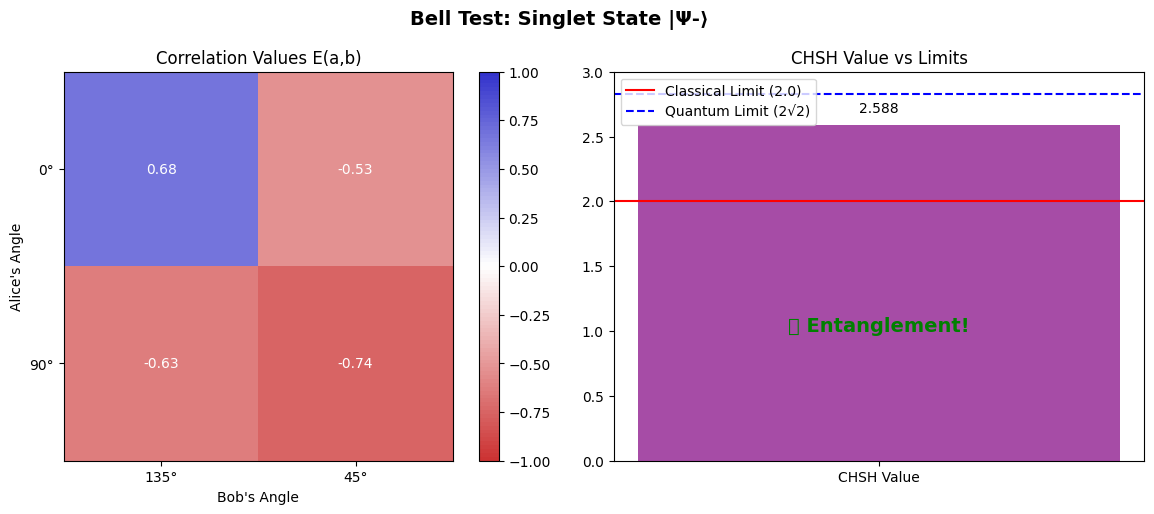

In [18]:
visualize_bell_test_results(correlations, chsh, "Bell Test: Singlet State |Ψ-⟩")

## Eavesdropping Detection

In [19]:
def create_eavesdropped_state(bell_qc):
    eve_qc = bell_qc.copy()
    eve_qc.measure_all()
    eve_result = run_circuit(eve_qc, shots=1)
    eve_bits = list(eve_result.keys())[0]
    
    qc = QuantumCircuit(2)
    if eve_bits[0] == '1':
        qc.x(1)
    if eve_bits[1] == '1':
        qc.x(0)
    
    return qc

In [20]:
# Test with Eve
EVE_PERCENTAGE = 0
print(f"Eve intercepts {EVE_PERCENTAGE*100}% of pairs")

bell_pairs = [create_bell_pair_singlet_state() for _ in range(num_experiments)]
compromised = int(num_experiments * EVE_PERCENTAGE)
eve_pairs = [create_eavesdropped_state(qc) for qc in bell_pairs[:compromised]] + bell_pairs[compromised:]

results, alice_bases_used, bob_bases_used = run_bell_test_measurements(eve_pairs)
organized = organize_measurements_by_basis(results, alice_bases_used, bob_bases_used)
correlations = calculate_correlations(organized)
chsh = calculate_chsh_value(correlations)

print(f"\nCHSH with Eve: {chsh:.4f}")

# Interpretation logic
if chsh > 2.0:
    print(" QUANTUM CORRELATIONS DETECTED!")
    print("   The system is entangled. The channel appears secure.")
    if EVE_PERCENTAGE > 0:
        print(f"   (Note: Eve was present at {EVE_PERCENTAGE*100}%, but didn't intercept enough to break the inequality.)")
else:
    print(" EAVESDROPPING DETECTED!")
    print("   The Bell inequality is satisfied (S ≤ 2).")
    print("   Alice and Bob should abort: the connection is NOT secure.")

Eve intercepts 0% of pairs
Correlations:
  E('0', '45') = -0.7826
  E('0', '135') = 0.5714
  E('90', '45') = -0.7083
  E('90', '135') = -0.9200

CHSH with Eve: 2.9824
 QUANTUM CORRELATIONS DETECTED!
   The system is entangled. The channel appears secure.


/var/folders/cn/8wc0t1212qv5q9y694bk0w6r0000gq/T/ipykernel_26046/2922408800.py:48: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/chei2402/venv_qiskit_2.1.2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


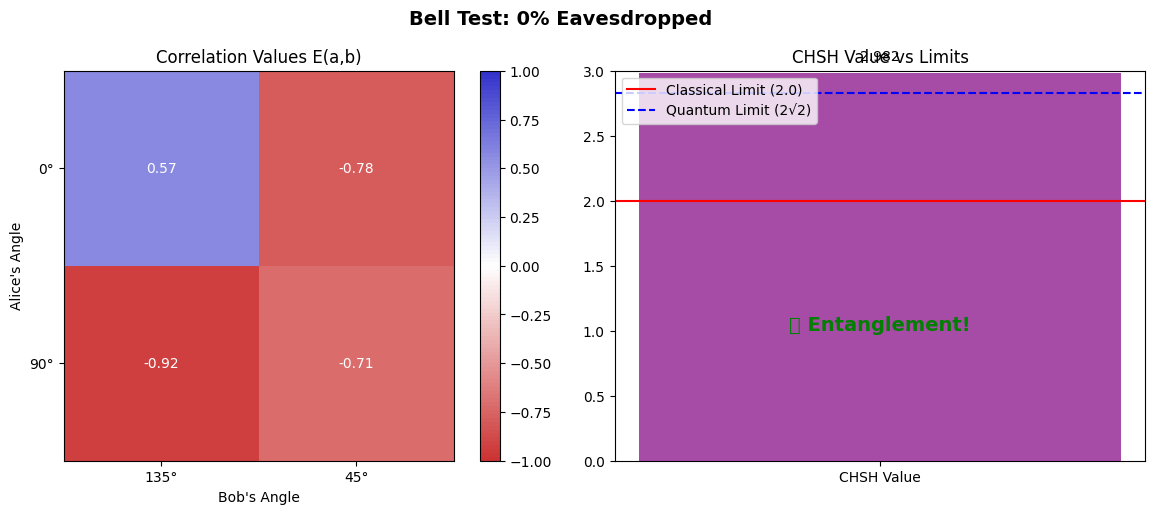

In [21]:
visualize_bell_test_results(correlations, chsh, f"Bell Test: {EVE_PERCENTAGE*100}% Eavesdropped")

---
## Summary

**Congratulations!** You've successfully:
- Created and visualized Bell pairs (singlet state |Ψ-⟩)
- Understood measurement bases and transformations
- Implemented the CHSH Bell inequality test
- Verified quantum entanglement (S > 2)
- Detected eavesdropping through CHSH violation changes

**Next:** In **Notebook 2 (E91 Protocol)**, we'll use these functions to implement a complete quantum key distribution protocol!